<a href="https://colab.research.google.com/github/OmarMachuca851/Task/blob/main/scratch_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rades Neuronales Recurrentes

In [ ]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
import matplotlib.pyplot as plt

## Propagación hacia delante y retropropagión

In [ ]:
class SimpleRNN:
    def __init__(self, input_dim, hidden_dim):
        self.w_x = np.random.randn(input_dim, hidden_dim) * 0.01
        self.w_h = np.random.randn(hidden_dim, hidden_dim) * 0.01
        self.b = np.zeros((1, hidden_dim))
    # forward prapagation
    def forward(self, x, h):
        n_sequences = x.shape[1]
        self.h_states = [h.copy()]
        self.x_inputs = []

        for n in range(n_sequences):
            x_step = x[:, n, :]
            h = np.tanh(x_step @ self.w_x + h @ self.w_h + self.b)
            self.h_states.append(h.copy())
            self.x_inputs.append(x_step.copy())

        return h
    # backward propagation
    def backward(self, dh, lr):
        n_sequences = len(self.x_inputs)

        dw_x = np.zeros_like(self.w_x)
        dw_h = np.zeros_like(self.w_h)
        db = np.zeros_like(self.b)

        dht = dh.copy()

        for n in reversed(range(n_sequences)):
            h_prev = self.h_states[n]
            h_curr = self.h_states[n+1]
            x_curr = self.x_inputs[n]

            dtanh = 1 - h_curr**2
            dlocal = dht * dtanh

            dw_x += x_curr.T @ dlocal
            dw_h += h_prev.T @ dlocal
            db += np.sum(dlocal, axis=0)

            dht = dlocal @ self.w_h.T
            self.w_x -= lr * dw_x
            self.w_h -= lr * dw_h
            self.b -= lr * db
        return dw_x, dw_h, db

rnn = SimpleRNN(2, 4)

x = np.array([[[1, 2], [2, 3], [3, 4]]])/100 # (batch_size, n_sequences, n_features)
w_x = np.array([[1, 3, 5, 7], [3, 5, 7, 8]])/100 # (n_features, n_nodes)
w_h = np.array([[1, 3, 5, 7], [2, 4, 6, 8], [3, 5, 7, 8], [4, 6, 8, 10]])/100 # (n_nodes, n_nodes)
batch_size = x.shape[0] # 1
n_sequences = x.shape[1] # 3
n_features = x.shape[2] # 2
n_nodes = w_x.shape[1] # 4
h = np.zeros((batch_size, n_nodes)) # (batch_size, n_nodes)
b = np.array([1, 1, 1, 1]) # (n_nodes,)

rnn.w_x = w_x
rnn.w_h = w_h
rnn.b = b

forward = rnn.forward(x, h)
forward

array([[0.79494228, 0.81839002, 0.83939649, 0.85584174]])

## implementación de clasificador RNN desde scratch

In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

class ScratchSimpleRNNClassifier:
    def __init__(self, input_dim, hidden_dim, output_dim, learning_rate=0.001, seq_len=10):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.learning_rate = learning_rate
        self.seq_len = seq_len

        # Inicialización Xavier/Glorot para mejores gradientes
        self.w_x = np.random.randn(input_dim, hidden_dim) * np.sqrt(2.0 / (input_dim + hidden_dim))
        self.w_h = np.random.randn(hidden_dim, hidden_dim) * np.sqrt(2.0 / (hidden_dim + hidden_dim))
        self.b_h = np.zeros((1, hidden_dim))

        self.w_y = np.random.randn(hidden_dim, output_dim) * np.sqrt(2.0 / (hidden_dim + output_dim))
        self.b_y = np.zeros((1, output_dim))

        self.loss_history = []
        self.accuracy_history = []

    def forward(self, x, h_prev):
        batch_size = x.shape[0]
        self.h_states = [h_prev.copy()]
        self.x_inputs = []

        # Procesar secuencia
        for t in range(self.seq_len):
            x_step = x[:, t, :]
            # Forward con estabilización numérica
            pre_activation = x_step @ self.w_x + h_prev @ self.w_h + self.b_h
            h_prev = np.tanh(pre_activation)

            self.h_states.append(h_prev.copy())
            self.x_inputs.append(x_step.copy())

        # Capa de salida
        scores = h_prev @ self.w_y + self.b_y
        probs = self.softmax(scores)

        return probs, h_prev

    def backward(self, x, y, probs):
        batch_size = x.shape[0]

        # Gradiente de la pérdida
        dscores = probs.copy()
        dscores[range(batch_size), y] -= 1
        dscores /= batch_size

        # Gradientes capa de salida
        dw_y = self.h_states[-1].T @ dscores
        db_y = np.sum(dscores, axis=0, keepdims=True)
        dh_next = dscores @ self.w_y.T

        # Gradientes RNN (BPTT)
        dw_x = np.zeros_like(self.w_x)
        dw_h = np.zeros_like(self.w_h)
        db_h = np.zeros_like(self.b_h)

        # Backprop through time
        for t in reversed(range(self.seq_len)):
            # Estado actual y anterior
            h_prev = self.h_states[t]
            h_curr = self.h_states[t+1]
            x_curr = self.x_inputs[t]

            # Gradiente de tanh
            dtanh = 1 - h_curr**2

            # Gradiente local
            dlocal = dh_next * dtanh

            # Acumular gradientes
            dw_x += x_curr.T @ dlocal
            dw_h += h_prev.T @ dlocal
            db_h += np.sum(dlocal, axis=0, keepdims=True)

            # Propagación hacia atrás
            dh_next = dlocal @ self.w_h.T

        # Clip de gradientes para evitar exploding gradients
        max_grad_norm = 5.0
        total_norm = np.sqrt(np.sum(dw_x**2) + np.sum(dw_h**2) + np.sum(dw_y**2))

        if total_norm > max_grad_norm:
            scale = max_grad_norm / (total_norm + 1e-6)
            dw_x *= scale
            dw_h *= scale
            dw_y *= scale
            db_h *= scale
            db_y *= scale

        return dw_x, dw_h, db_h, dw_y, db_y

    def softmax(self, x):
        # Softmax estabilizado
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def compute_loss(self, probs, y):
        batch_size = probs.shape[0]
        correct_logprobs = -np.log(probs[range(batch_size), y] + 1e-8)
        return np.sum(correct_logprobs) / batch_size

    def fit(self, X, y, epochs=100, batch_size=32, validation_data=None, verbose=True):
        X_train, y_train = X, y
        X_val, y_val = validation_data if validation_data else (None, None)

        for epoch in range(epochs):
            # Mezclar datos
            indices = np.random.permutation(len(X_train))
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]

            epoch_loss = 0
            epoch_accuracy = 0
            batch_count = 0

            for i in range(0, len(X_shuffled), batch_size):
                # Batch actual
                end_idx = min(i + batch_size, len(X_shuffled))
                X_batch = X_shuffled[i:end_idx]
                y_batch = y_shuffled[i:end_idx]

                # Estado oculto inicial
                h_prev = np.zeros((X_batch.shape[0], self.hidden_dim))

                # Forward pass
                probs, _ = self.forward(X_batch, h_prev)

                # Calcular pérdida y accuracy
                loss = self.compute_loss(probs, y_batch)
                predictions = np.argmax(probs, axis=1)
                accuracy = np.mean(predictions == y_batch)

                # Backward pass
                dw_x, dw_h, db_h, dw_y, db_y = self.backward(X_batch, y_batch, probs)

                # Actualizar parámetros
                self.w_x -= self.learning_rate * dw_x
                self.w_h -= self.learning_rate * dw_h
                self.b_h -= self.learning_rate * db_h
                self.w_y -= self.learning_rate * dw_y
                self.b_y -= self.learning_rate * db_y

                epoch_loss += loss
                epoch_accuracy += accuracy
                batch_count += 1

            # Promedio de la época
            epoch_loss /= batch_count
            epoch_accuracy /= batch_count

            self.loss_history.append(epoch_loss)
            self.accuracy_history.append(epoch_accuracy)

            # Validación
            val_accuracy = 0
            if X_val is not None:
                val_pred = self.predict(X_val)
                val_accuracy = accuracy_score(y_val, val_pred)

            if verbose and epoch % 10 == 0:
                val_str = f", Val Accuracy: {val_accuracy:.4f}" if X_val is not None else ""
                print(f"Epoch {epoch}: Loss = {epoch_loss:.4f}, Train Accuracy = {epoch_accuracy:.4f}{val_str}")

    def predict(self, X):
        batch_size = X.shape[0]
        h_prev = np.zeros((batch_size, self.hidden_dim))
        probs, _ = self.forward(X, h_prev)
        return np.argmax(probs, axis=1)

# Generar datos SECUENCIALES realistas que una RNN pueda aprender
def generate_sequential_data(n_samples=1000, seq_len=10, n_features=5, n_classes=3):
    X = np.zeros((n_samples, seq_len, n_features))
    y = np.zeros(n_samples, dtype=int)

    for i in range(n_samples):
        # Elegir clase
        class_label = np.random.randint(n_classes)
        y[i] = class_label

        # Crear patrón secuencial dependiente de la clase
        base_pattern = np.random.randn(n_features) * 0.1

        for t in range(seq_len):
            # Patrón que evoluciona en el tiempo y depende de la clase
            time_factor = np.sin(t * 0.5 + class_label * 2) * 0.5
            class_factor = class_label * 0.3

            # Ruido + patrón de clase + evolución temporal
            X[i, t, :] = (base_pattern +
                         class_factor +
                         time_factor +
                         np.random.randn(n_features) * 0.1)

    return X, y

## Aprendizaje y estimación

Generando datos secuenciales...
Shapes - Train: (1400, 8, 100), Val: (300, 8, 100), Test: (300, 8, 100)

Entrenando modelo RNN mejorado...
Epoch 0: Loss = 1.4948, Train Accuracy = 0.3319, Val Accuracy: 0.3533
Epoch 10: Loss = 0.4190, Train Accuracy = 0.9943, Val Accuracy: 0.9967
Epoch 20: Loss = 0.1533, Train Accuracy = 1.0000, Val Accuracy: 1.0000
Epoch 30: Loss = 0.0872, Train Accuracy = 1.0000, Val Accuracy: 1.0000
Epoch 40: Loss = 0.0592, Train Accuracy = 1.0000, Val Accuracy: 1.0000
Epoch 50: Loss = 0.0443, Train Accuracy = 1.0000, Val Accuracy: 1.0000
Epoch 60: Loss = 0.0352, Train Accuracy = 1.0000, Val Accuracy: 1.0000
Epoch 70: Loss = 0.0291, Train Accuracy = 1.0000, Val Accuracy: 1.0000
Epoch 80: Loss = 0.0247, Train Accuracy = 1.0000, Val Accuracy: 1.0000
Epoch 90: Loss = 0.0215, Train Accuracy = 1.0000, Val Accuracy: 1.0000

Resultados finales:
Train Accuracy: 1.0000
Test Accuracy: 1.0000


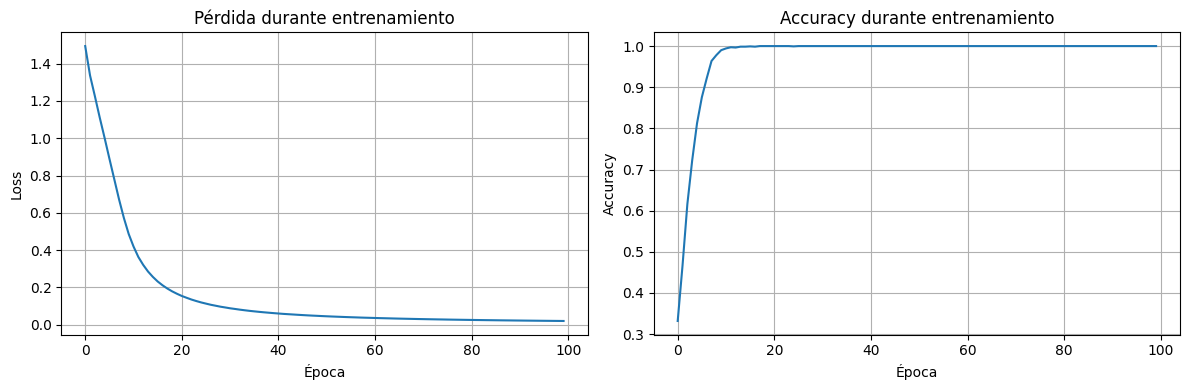

In [ ]:
# Prueba con datos mejorados
print("Generando datos secuenciales...")
X, y = generate_sequential_data(n_samples=2000, seq_len=8, n_features=100, n_classes=5)

# Split train-val-test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



print(f"Shapes - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# Crear y entrenar modelo
print("\nEntrenando modelo RNN mejorado...")
rnn = ScratchSimpleRNNClassifier(
    input_dim=100,
    hidden_dim=16,  # Reducido para mejor aprendizaje
    output_dim=5,
    learning_rate=0.005,  # Learning rate ajustado
    seq_len=8
)

# Entrenar con datos de validación
rnn.fit(X_train, y_train, epochs=100, batch_size=32,
        validation_data=(X_val, y_val), verbose=True)

# Evaluación final
train_pred = rnn.predict(X_train)
test_pred = rnn.predict(X_test)

train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)

print(f"\nResultados finales:")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Visualizar progreso
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(rnn.loss_history)
plt.title('Pérdida durante entrenamiento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(rnn.accuracy_history)
plt.title('Accuracy durante entrenamiento')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()